In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from pathlib import Path
import re
from visu_utils import TASK_LIST_CLUSTERING

from autorank import autorank, plot_stats, create_report, latex_table



EXPORT_PATH_TABLE = Path("../../papers/Distillation-MI-ICLR/tables/nlp/")
EXPORT_PATH_FIG = Path("../../papers/Distillation-MI-ICLR/figures/nlp/")

# Make sure the folders exist
EXPORT_PATH_TABLE.mkdir(parents=True, exist_ok=True)
EXPORT_PATH_FIG.mkdir(parents=True, exist_ok=True)


In [2]:

# load mteb clustering

MTEB_BASELINES_PATH =  Path("../non_sync/baselines_mteb/mteb_detailed/en_Clustering.csv")
df_mteb_clustering = pd.read_csv(MTEB_BASELINES_PATH)
df_mteb_clustering



def extract_url_from_html_link(html):
    return re.findall(r'href=[\'"]?([^\'" >]+)', html)[0]

df_mteb_clustering['Model'] = df_mteb_clustering['Model'].apply(extract_url_from_html_link)
df_mteb_clustering['Model'] = df_mteb_clustering['Model'].apply(lambda x: "/".join(x.split("/")[-2:]))

# Remove models with "test" in the name
df_mteb_clustering = df_mteb_clustering[~df_mteb_clustering['Model'].str.contains("test")]

df_mteb_clustering


,index,Rank,Model,Model Size (Million Parameters),"Memory Usage (GB, fp32)",Embedding Dimensions,Max Tokens,Average,ArxivClusteringP2P,ArxivClusteringS2S,BiorxivClusteringP2P,BiorxivClusteringS2S,MedrxivClusteringP2P,MedrxivClusteringS2S,RedditClustering,RedditClusteringP2P,StackExchangeClustering,StackExchangeClusteringP2P,TwentyNewsgroupsClustering
0,223,1,nvidia/NV-Embed-v2,7851.0,29.25,4096.0,32768.0,58.46,55.80,51.26,54.09,49.60,46.09,44.86,71.10,74.94,82.10,48.36,64.82
1,22,2,BAAI/bge-en-icl,7111.0,26.49,4096.0,32768.0,57.89,54.44,49.33,53.05,48.38,45.86,44.33,72.33,72.72,81.32,46.05,68.98
2,153,3,dunzhang/stella_en_1.5B_v5,1543.0,5.75,8192.0,131072.0,57.69,55.44,50.66,50.68,46.87,46.87,44.65,72.86,75.27,80.29,49.57,61.43
3,17,4,Alibaba-NLP/gte-Qwen2-7B-instruct,7613.0,28.36,3584.0,131072.0,56.92,56.46,51.74,50.09,46.65,46.23,44.13,73.55,74.13,79.86,49.41,53.91
4,27,5,BN7002/gte-Qwen2-7B-instruct-Q4_K_M-GGUF,NaN,NaN,NaN,NaN,56.92,56.46,51.74,50.09,46.65,46.23,44.13,73.55,74.13,79.86,49.41,53.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,297,304,blog/introducing-text-and-code-embeddings,NaN,NaN,4096.0,2046.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
283,298,305,blog/introducing-text-and-code-embeddings,NaN,NaN,12288.0,2046.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
284,300,306,blog/introducing-text-and-code-embeddings,NaN,NaN,2048.0,2046.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.64,NaN,53.01,NaN,42.01
285,301,307,blog/introducing-text-and-code-embeddings,NaN,NaN,4096.0,2046.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.79,NaN,55.14,NaN,37.64


In [3]:

OURS_SIZES = {'xs' : 23, "s" : 33, "m" : 109, "l" : 335}


MTEB_PATHS_NLL = Path("../non_sync/mteb_benchmarking/results/experiments_gist_nll")
MTEB_PATHS_MSE = Path("../non_sync/mteb_benchmarking/results/experiments_gist_mse")

def load_ours(MTEB_PATHS):
    # list all json
    json_files = list(MTEB_PATHS.rglob("*.json"))

    # load all json
    data = []
    for json_file in json_files:
        with open(json_file, "r") as f:
            data.append(json.load(f))


    records = []


    for path, results in zip(json_files, data):
        model_ref = path.parts[-4]
        expe_name = path.parts[-5]
        expe = path.parts[-7]
        step = int(model_ref.split("=")[-1])

        if path.stem == "model_meta":
            continue
            

            
            
        dataset = "BIG" if not "gist" in expe else "GIST"
        loss = "NLL" if "nll" in expe else "MSE"
        model = f"OURS/{loss}/{dataset}-{expe_name}-{step}"
        


        main_score = results['scores']['test'][0]['main_score']
        task_name = results['task_name']


        if task_name not in TASK_LIST_CLUSTERING:
            continue
        records.append({
            "Model": model,
            # "Training step": step,
            "loss" : loss,
            "Dataset": dataset,
            "Task": task_name,
            "Score": main_score * 100,
            "Model Size (Million Parameters)": OURS_SIZES[expe_name.split('-')[-1]],
        })

    df = pd.DataFrame(records)



    # Index(['model', 'Task', 'Score', 'Model Size (Million Parameters)'], dtype='object')

    # make columns with Task content filled with Score
    df_ = df.pivot(index=['Model', 'Model Size (Million Parameters)', 'loss', 'Dataset'], columns='Task', values='Score')
    # add " (en)" to the column names

    # source columns
    # Index(['AmazonCounterfactualClassification', 'AmazonPolarityClassification',
    #        'AmazonReviewsClassification', 'Banking77Classification',
    #        'EmotionClassification', 'ImdbClassification',
    #        'MTOPDomainClassification', 'MTOPIntentClassification',
    #        'MassiveIntentClassification', 'MassiveScenarioClassification',
    #        'ToxicConversationsClassification',
    #        'TweetSentimentExtractionClassification'],
    #       dtype='object', name='Task')



    # Target columns
    # Index(['Rank', 'Model', 'Model Size (Million Parameters)',
    #        'Memory Usage (GB, fp32)', 'Average',
    #        'AmazonCounterfactualClassification (en)',
    #        'AmazonPolarityClassification', 'AmazonReviewsClassification (en)',
    #        'Banking77Classification', 'EmotionClassification',
    #        'ImdbClassification', 'MassiveIntentClassification (en)',
    #        'MassiveScenarioClassification (en)', 'MTOPDomainClassification (en)',
    #        'MTOPIntentClassification (en)', 'ToxicConversationsClassification',
    #        'TweetSentimentExtractionClassification', 'Subset', 'Task category'],
    #       dtype='object')

    COLUMN_MAPPING = {
        "AmazonCounterfactualClassification" : "AmazonCounterfactualClassification (en)",
        "AmazonReviewsClassification" : "AmazonReviewsClassification (en)",
        "MassiveIntentClassification" : "MassiveIntentClassification (en)",
        "MassiveScenarioClassification" : "MassiveScenarioClassification (en)",
        "MTOPDomainClassification" : "MTOPDomainClassification (en)",
        "MTOPIntentClassification" : "MTOPIntentClassification (en)",
    }

    df_ = df_.rename(columns=COLUMN_MAPPING)

    df_ = df_.reset_index()


    return df, df_

df_nll, df_nll_ = load_ours(MTEB_PATHS_NLL)
# df_mse, df_mse_ = load_ours(MTEB_PATHS_MSE)


In [4]:

df_nll_




Task,Model,Model Size (Million Parameters),loss,Dataset,ArxivClusteringP2P,ArxivClusteringS2S,RedditClustering,RedditClusteringP2P,StackExchangeClustering,StackExchangeClusteringP2P,TwentyNewsgroupsClustering
0,OURS/NLL/GIST-snowflake-arctic-embed-m-28000,109,NLL,GIST,47.600702,38.664194,57.290455,62.811736,65.509472,33.599573,47.721025
1,OURS/NLL/GIST-snowflake-arctic-embed-m-54000,109,NLL,GIST,47.821658,38.823478,56.987716,61.003845,65.933605,33.886318,48.698156
2,OURS/NLL/GIST-snowflake-arctic-embed-m-68000,109,NLL,GIST,47.728607,38.721918,56.278965,61.523439,64.655865,33.843269,46.596227
3,OURS/NLL/GIST-snowflake-arctic-embed-s-34000,33,NLL,GIST,45.771633,35.725088,53.535811,60.861682,61.416084,32.456057,45.959106
4,OURS/NLL/GIST-snowflake-arctic-embed-s-48000,33,NLL,GIST,45.715161,35.327869,53.411500,59.421158,61.483557,32.273848,46.158068
5,OURS/NLL/GIST-snowflake-arctic-embed-s-72000,33,NLL,GIST,45.685566,35.552508,52.503919,60.336117,60.601500,32.246335,45.144377
6,OURS/NLL/GIST-snowflake-arctic-embed-s-96000,33,NLL,GIST,45.854248,35.214716,51.911016,60.291415,61.457940,32.254829,45.084456
7,OURS/NLL/GIST-snowflake-arctic-embed-xs-110000,23,NLL,GIST,45.111659,33.709002,52.391414,58.544281,59.260190,33.144377,44.177950
8,OURS/NLL/GIST-snowflake-arctic-embed-xs-142000,23,NLL,GIST,45.215166,33.898452,52.138519,58.100985,59.904538,33.067741,44.338147
9,OURS/NLL/GIST-snowflake-arctic-embed-xs-48000,23,NLL,GIST,44.707301,33.667984,52.821262,58.033203,58.532708,33.143057,44.417626


In [5]:
# merge with mteb with clustering

df_mteb_clustering['loss'] = "N/A"
df_mteb_clustering['Dataset'] = "N/A"
df_merged = pd.concat([df_mteb_clustering, df_nll_], ignore_index=True)[df_nll_.columns]


df_merged = df_merged.dropna()

df_merged



,Model,Model Size (Million Parameters),loss,Dataset,ArxivClusteringP2P,ArxivClusteringS2S,RedditClustering,RedditClusteringP2P,StackExchangeClustering,StackExchangeClusteringP2P,TwentyNewsgroupsClustering
0,nvidia/NV-Embed-v2,7851.0,N/A,N/A,55.800000,51.260000,71.100000,74.940000,82.100000,48.360000,64.820000
1,BAAI/bge-en-icl,7111.0,N/A,N/A,54.440000,49.330000,72.330000,72.720000,81.320000,46.050000,68.980000
2,dunzhang/stella_en_1.5B_v5,1543.0,N/A,N/A,55.440000,50.660000,72.860000,75.270000,80.290000,49.570000,61.430000
3,Alibaba-NLP/gte-Qwen2-7B-instruct,7613.0,N/A,N/A,56.460000,51.740000,73.550000,74.130000,79.860000,49.410000,53.910000
5,dunzhang/stella_en_400M_v5,435.0,N/A,N/A,55.160000,49.820000,71.190000,74.420000,78.490000,48.900000,58.570000
...,...,...,...,...,...,...,...,...,...,...,...
289,OURS/NLL/GIST-snowflake-arctic-embed-s-96000,33.0,NLL,GIST,45.854248,35.214716,51.911016,60.291415,61.457940,32.254829,45.084456
290,OURS/NLL/GIST-snowflake-arctic-embed-xs-110000,23.0,NLL,GIST,45.111659,33.709002,52.391414,58.544281,59.260190,33.144377,44.177950
291,OURS/NLL/GIST-snowflake-arctic-embed-xs-142000,23.0,NLL,GIST,45.215166,33.898452,52.138519,58.100985,59.904538,33.067741,44.338147
292,OURS/NLL/GIST-snowflake-arctic-embed-xs-48000,23.0,NLL,GIST,44.707301,33.667984,52.821262,58.033203,58.532708,33.143057,44.417626


In [6]:

# Keep models with only Model Size (Million Parameters) between 10 and 300
df_merged = df_merged[(df_merged['Model Size (Million Parameters)'] >= 10) & (df_merged['Model Size (Million Parameters)'] <= 450)]

# remove lines with nan




In [7]:
# melt columns back into rows with Score
df_melted = df_merged.melt(id_vars=['Model', 'Model Size (Million Parameters)', 'loss', 'Dataset'], value_vars=df_merged.columns[4:], var_name='Task', value_name='Score')

In [8]:
df_melted

,Model,Model Size (Million Parameters),loss,Dataset,Task,Score
0,dunzhang/stella_en_400M_v5,435.0,N/A,N/A,ArxivClusteringP2P,55.160000
1,Alibaba-NLP/gte-large-en-v1.5,434.0,N/A,N/A,ArxivClusteringP2P,48.470000
2,Labib11/MUG-B-1.6,335.0,N/A,N/A,ArxivClusteringP2P,49.030000
3,thenlper/gte-large,335.0,N/A,N/A,ArxivClusteringP2P,48.620000
4,Alibaba-NLP/gte-base-en-v1.5,137.0,N/A,N/A,ArxivClusteringP2P,47.510000
...,...,...,...,...,...,...
779,OURS/NLL/GIST-snowflake-arctic-embed-s-96000,33.0,NLL,GIST,TwentyNewsgroupsClustering,45.084456
780,OURS/NLL/GIST-snowflake-arctic-embed-xs-110000,23.0,NLL,GIST,TwentyNewsgroupsClustering,44.177950
781,OURS/NLL/GIST-snowflake-arctic-embed-xs-142000,23.0,NLL,GIST,TwentyNewsgroupsClustering,44.338147
782,OURS/NLL/GIST-snowflake-arctic-embed-xs-48000,23.0,NLL,GIST,TwentyNewsgroupsClustering,44.417626


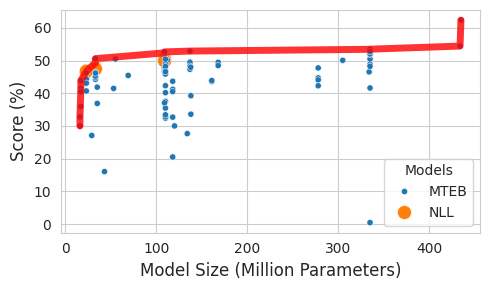

In [9]:

sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 1, figsize=(5, 3))

df_avg = df_melted.groupby(['Model', 'loss']).mean(numeric_only=True)
df_avg = df_avg.reset_index()

# rename loss
df_avg['loss'] = df_avg['loss'].replace({"N/A": "MTEB"})
# rename column loss
df_avg = df_avg.rename(columns={"loss": "Models"})

# keep only less than 50M 
df_avg = df_avg[df_avg['Model Size (Million Parameters)'] <= 450]

sns.scatterplot(data=df_avg, x='Model Size (Million Parameters)', y='Score', hue='Models', size="Models", sizes=(100, 20), ax=ax)

def trace_pareto_frontier(df, x, y, ax):
    df = df.sort_values(x)
    pareto_front = [df.iloc[0]]
    for i in range(1, len(df)):
        if df.iloc[i][y] >= pareto_front[-1][y]:
            pareto_front.append(df.iloc[i])
    pareto_front = pd.DataFrame(pareto_front)
    ax.plot(pareto_front[x], pareto_front[y], 'r-', lw=5, alpha=0.8)
    
trace_pareto_frontier(df_avg, 'Model Size (Million Parameters)', 'Score', ax)

# Change label sizes
ax.set_xlabel("Model Size (Million Parameters)", fontsize=12)
ax.set_ylabel("Score (%)", fontsize=12)

# export
fig.tight_layout()
fig.savefig(EXPORT_PATH_FIG / "pareto_frontier_clustering_nlp_less_110.png")



In [10]:

# Rank models for each task by Score

df_melted['Rank'] = df_melted.groupby('Task')['Score'].rank(ascending=False, method='min')

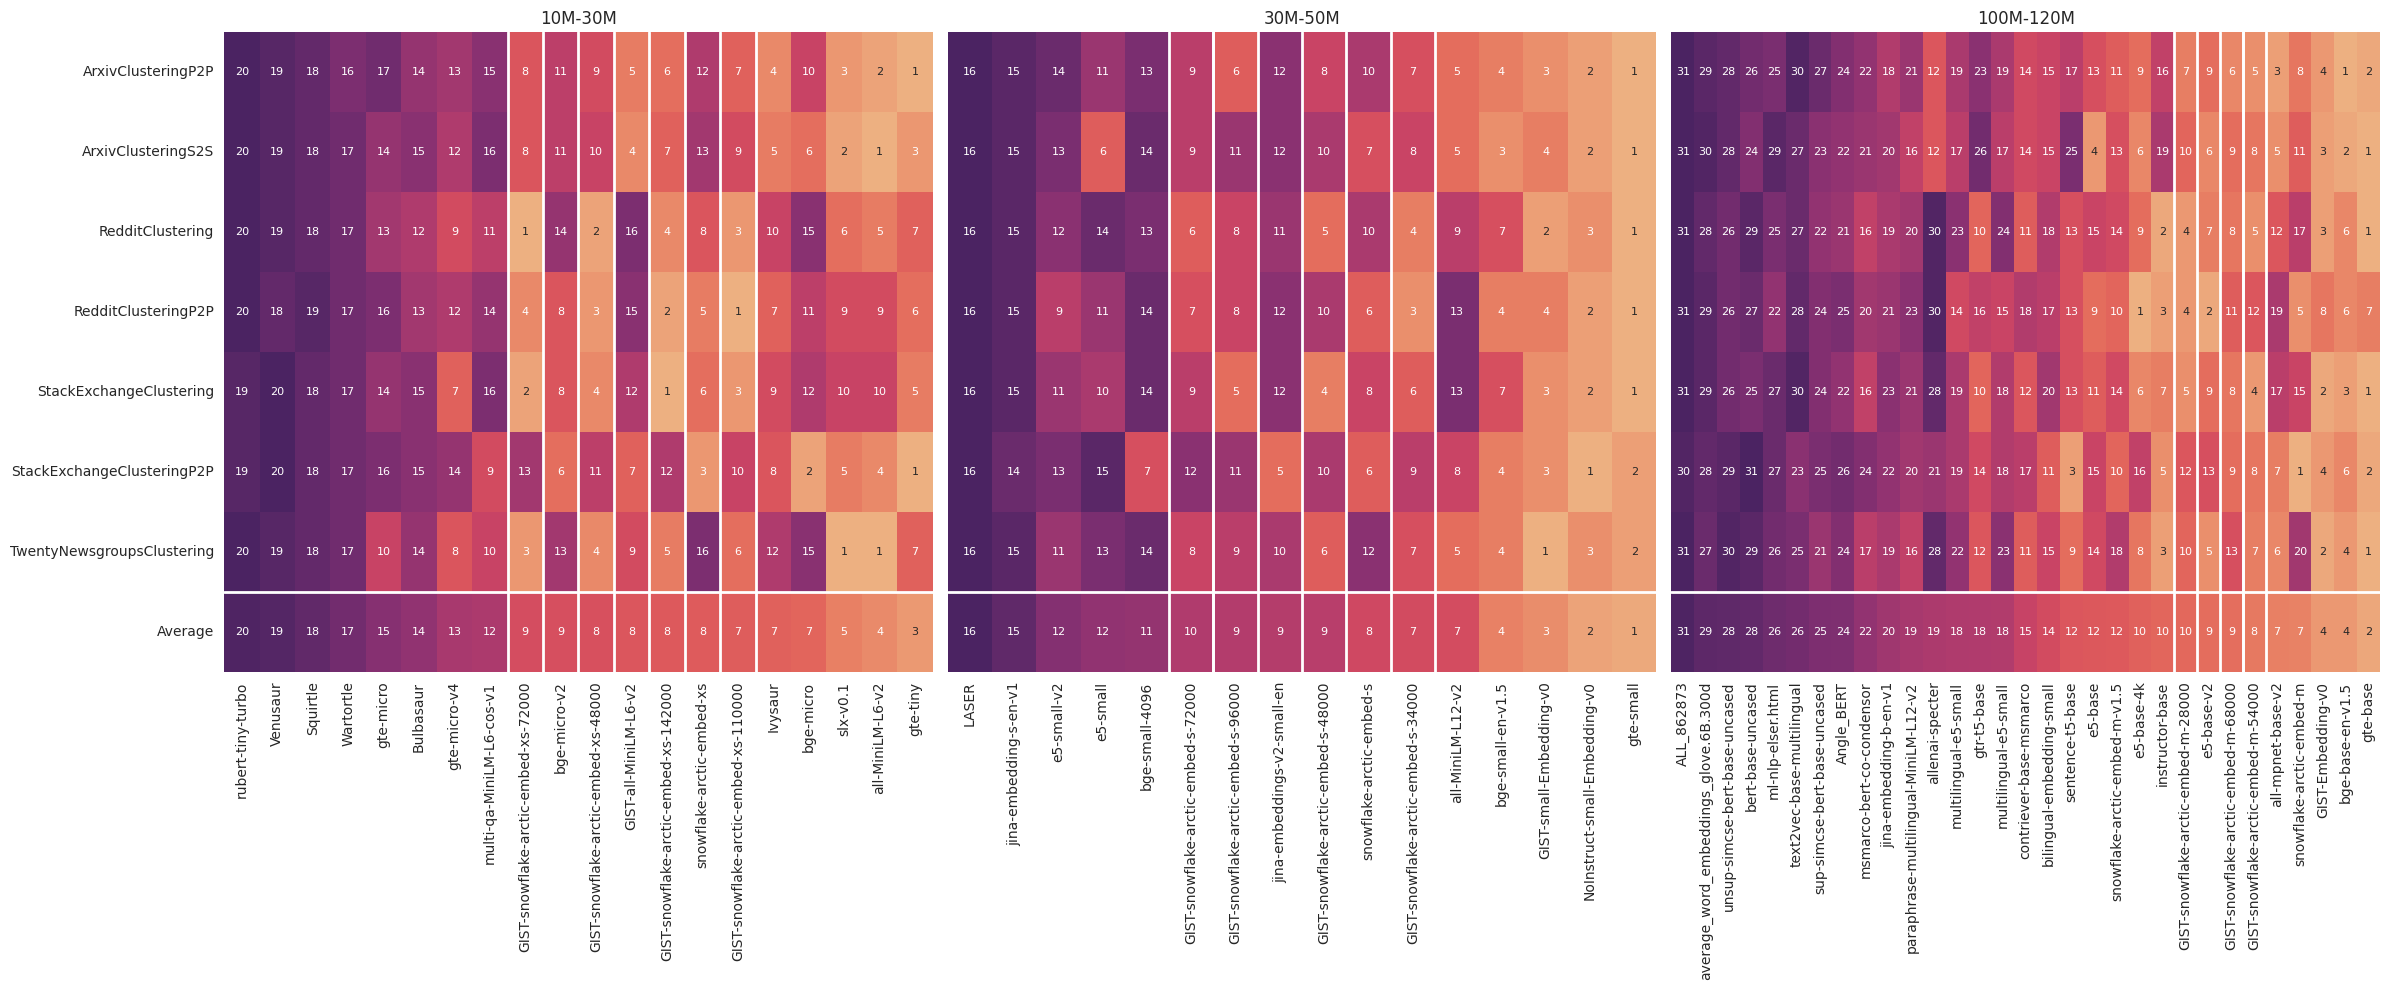

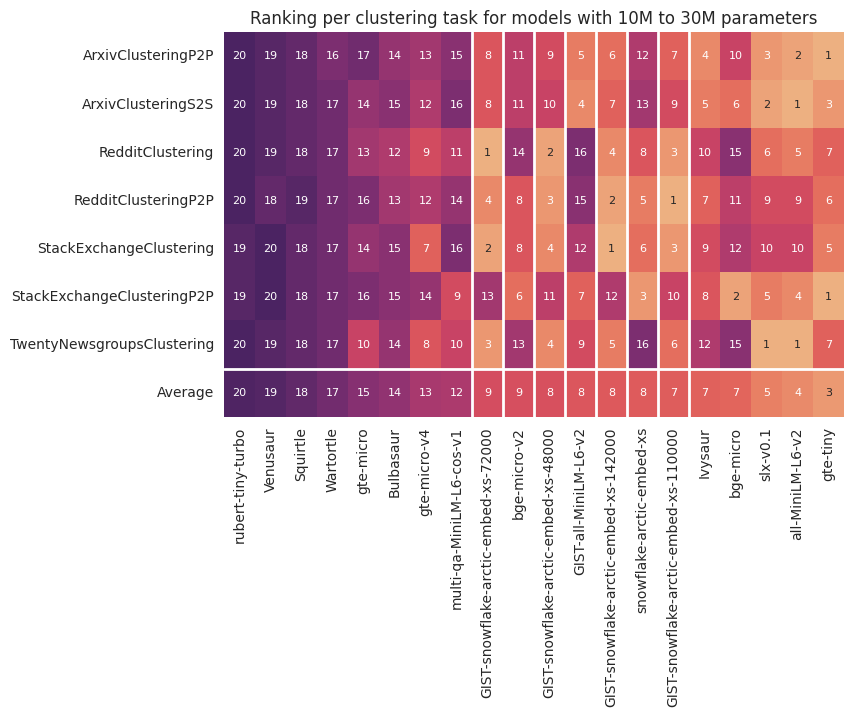

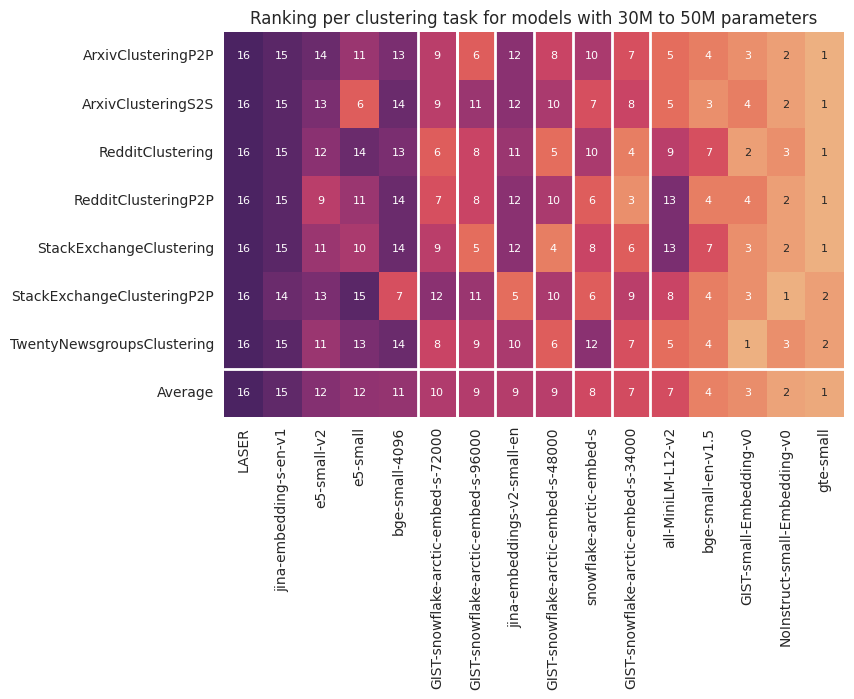

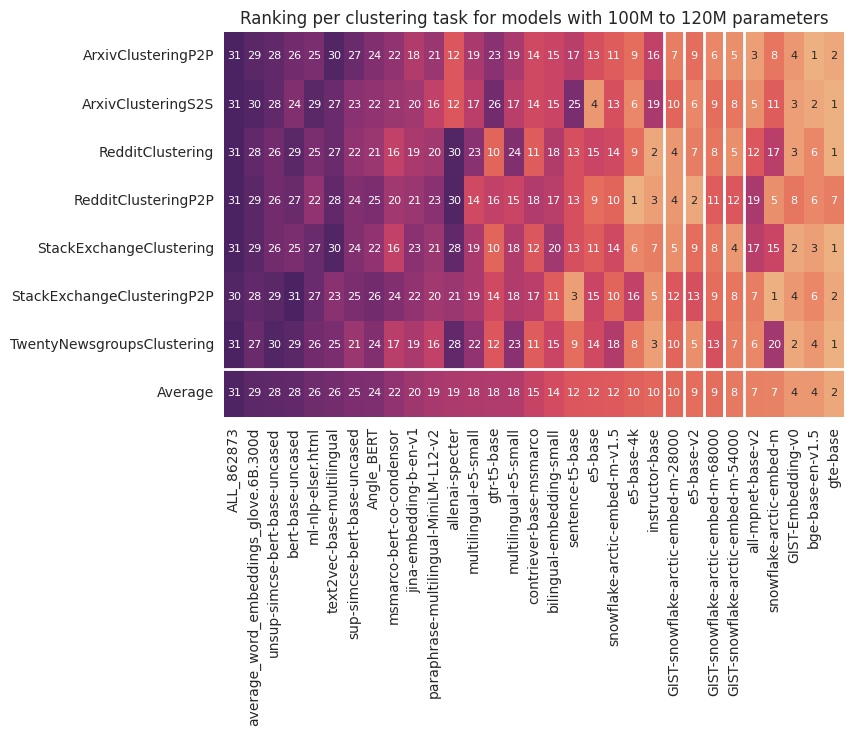

In [11]:

size_ranges = [(10, 30), (30, 50), (100, 120)]

fig, axes = plt.subplots(1, 3, figsize=(24, 10), sharey=True)
for k, (low, high) in enumerate(size_ranges):
    figloc, axloc = plt.subplots(1, 1, figsize=(8, 5))
    ax = axes[k]
    df_rank = df_melted[(df_melted['Model Size (Million Parameters)'] >= low) & (df_melted['Model Size (Million Parameters)'] <= high)].copy()
    
    df_rank['Rank'] = df_rank.groupby('Task')['Score'].rank(ascending=False, method='min')
    
    std_per_task = df_rank.groupby('Task')['Score'].std()
    # normalize in [0, 1]
    std_per_task = (std_per_task - std_per_task.min()) / (std_per_task.max() - std_per_task.min())
    
    df_rank = df_rank.pivot_table(index='Model', columns='Task', values='Rank')
    
    # drop nan
    df_rank = df_rank.dropna()
    
    # rename task columns: remove "Classification"
    df_rank.columns = [col.replace("Classification", "") for col in df_rank.columns]
    # remove " (en)"
    df_rank.columns = [col.replace(" (en)", "") for col in df_rank.columns]
    
    
    df_rank['Average'] = df_rank.apply(lambda x: np.average(x, weights=1-std_per_task), axis=1)
    df_rank = df_rank.sort_values('Average', ascending=False)
    # get Average index in the df_rank
    average_index = df_rank.T.index.get_loc('Average')
    
    ours = []
    for k, model in enumerate(df_rank.index):
        if "OURS" in model:
            ours.append((k, k+1))
            
        

    df_rank.index = [line.split('/')[-1] for line in df_rank.index]
    sns.heatmap(df_rank.T,ax = ax, cmap='flare', annot_kws={"size": 8}, annot=True, fmt=".0f", cbar=False)
    # draw hline at average index
    ax.axhline(average_index, color='white', lw=2)
    ax.set_title(f"{low}M-{high}M")
    
    # add hline for ours
    for k, (start, end) in enumerate(ours):
        ax.axvline(start, color='white', lw=2)
        ax.axvline(end, color='white', lw=2)
    
    sns.heatmap(df_rank.T,ax = axloc, cmap='flare', annot_kws={"size": 8}, annot=True, fmt=".0f", cbar=False)
    axloc.set_title(f"Ranking per clustering task for models with {low}M to {high}M parameters")
    axloc.axhline(average_index, color='white', lw=2)
    
    for k, (start, end) in enumerate(ours):
        axloc.axvline(start, color='white', lw=2)
        axloc.axvline(end, color='white', lw=2)
    
    figloc.savefig(EXPORT_PATH_FIG / f"ranking_clustering_per_size_{low}_{high}.png", bbox_inches='tight')
    
    
    # export
# fig.savefig(EXPORT_PATH_FIG / f"ranking_clustering_per_size_{low}_{high}.png", bbox_inches='tight')

fig.tight_layout()
fig.savefig(EXPORT_PATH_FIG / f"ranking_clustering_per_size.png", bbox_inches='tight')


    
    
    
    

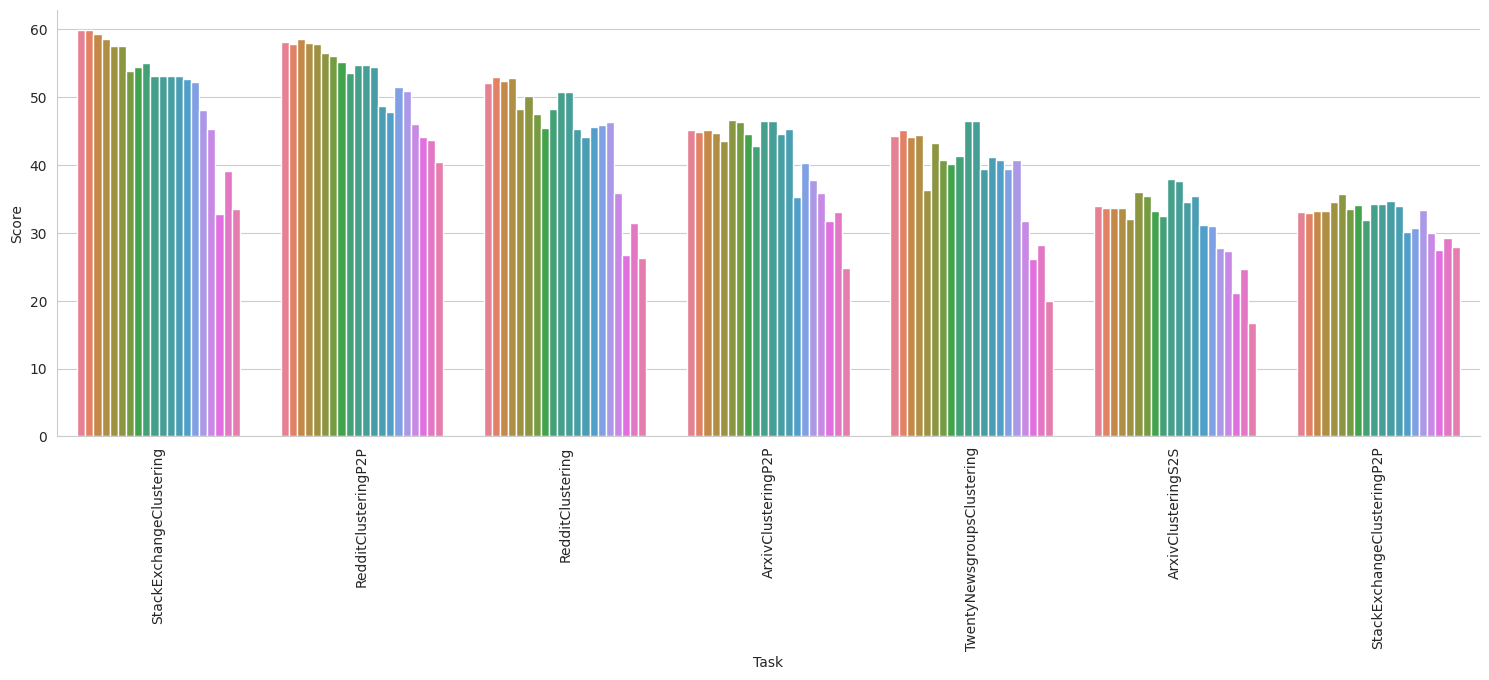

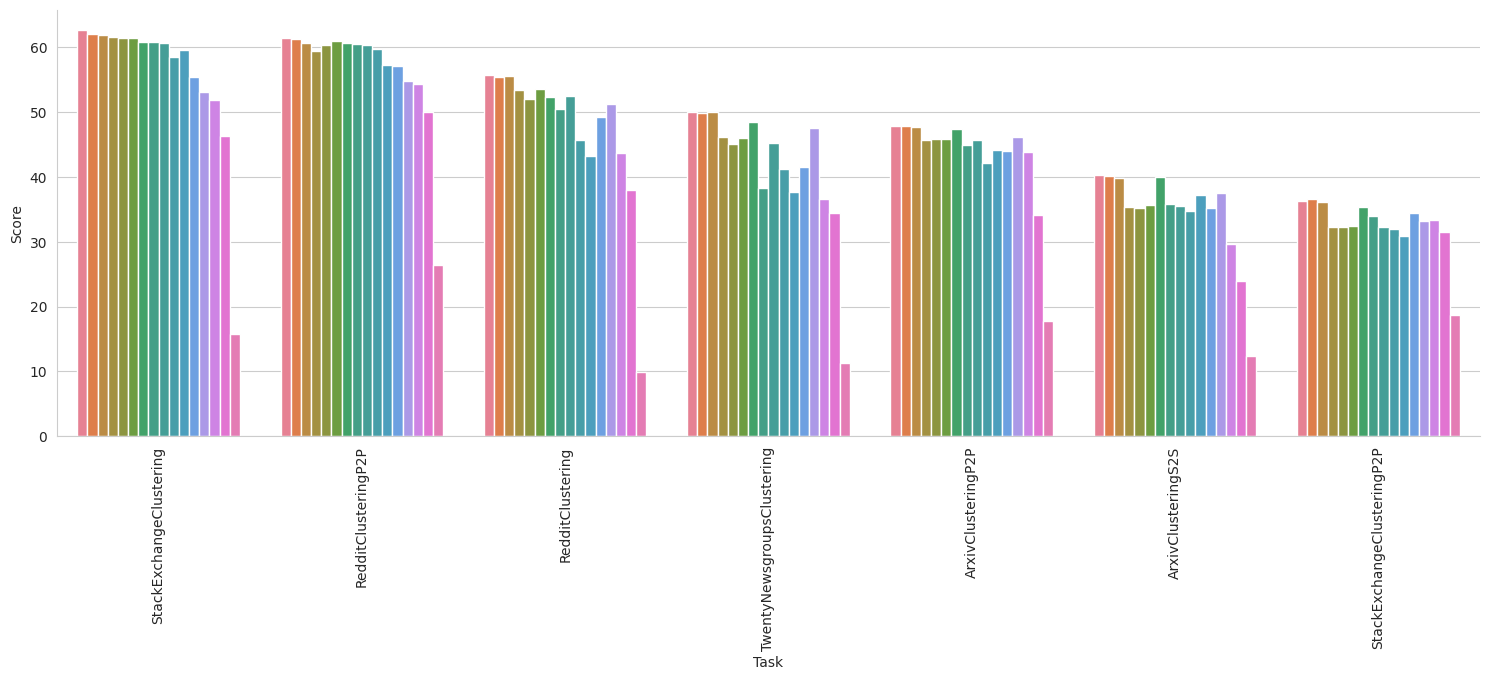

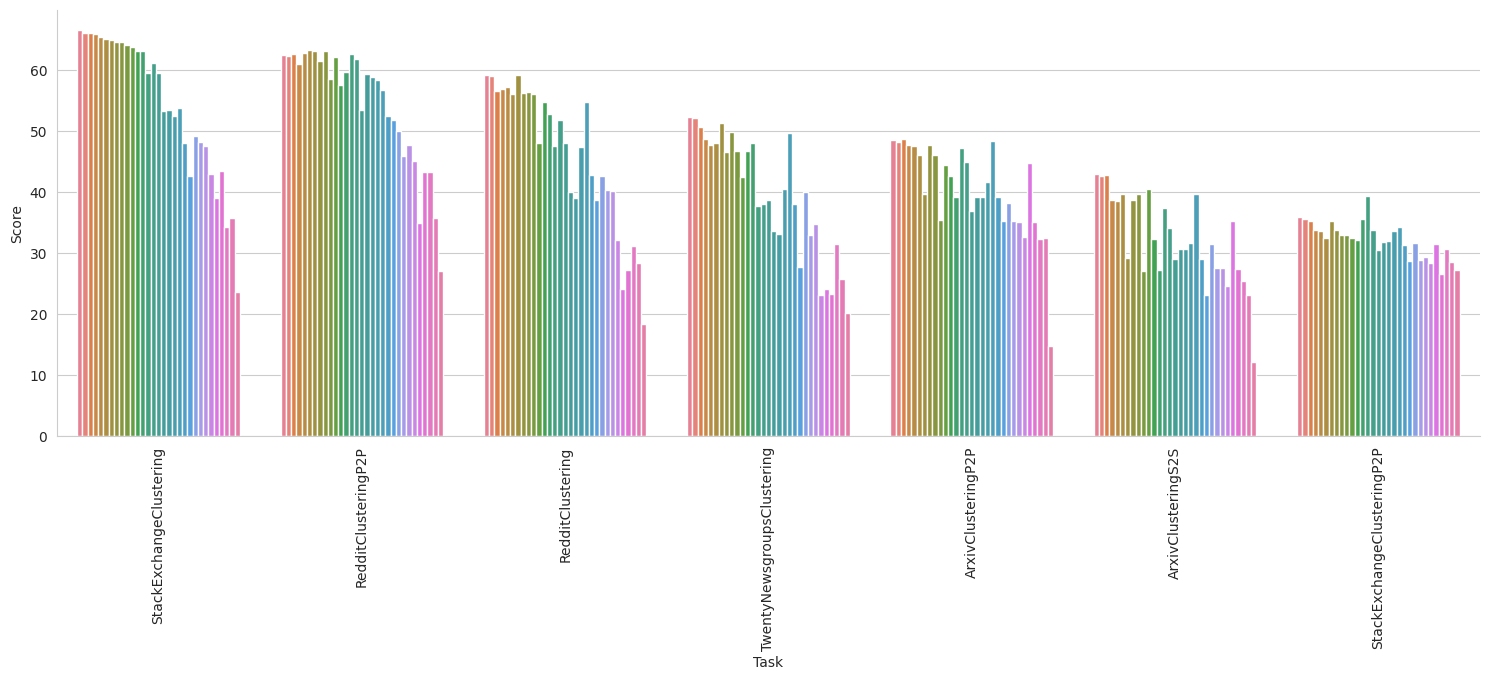

In [12]:


for k, (low, high) in enumerate(size_ranges):
    ax = axes[k]
    df_rank = df_melted[(df_melted['Model Size (Million Parameters)'] >= low) & (df_melted['Model Size (Million Parameters)'] <= high)].copy()
    
    # sort model per accuracy
    df_rank = df_rank.sort_values('Score', ascending=False)
    
    sns.catplot(data=df_rank, x='Task', y='Score', hue='Model', kind='bar', aspect=3, height=5, legend=False)
    plt.xticks(rotation=90)





In [13]:





def highlight_top_1(s, props=""):
    max_value = s.max()
    is_max = s == max_value
    return [props if v else '' for v in is_max]

def highlight_top_2(s, props=""):
    max_values = s.nlargest(2)
    is_max = s.isin(max_values)
    return [props if v else '' for v in is_max]
    

size_ranges = [(10, 30), (30, 50), (100, 120)]

idx = pd.IndexSlice
for k, (low, high) in enumerate(size_ranges):
    latex_results = df_melted[(df_melted['Model Size (Million Parameters)'] >= low) & (df_melted['Model Size (Million Parameters)'] <= high)]

    # Pivot table
    df_pivot = latex_results.pivot_table(index=['loss', 'Model', 'Model Size (Million Parameters)', 'Dataset'], columns='Task', values='Score')
    df_pivot = df_pivot
    
    # Find and remove "Classification" in the column names
    df_pivot.columns = [col.replace("Classification", "") for col in df_pivot.columns]
    
    # Split at capital letters that are between two letters
    
    df_pivot.columns = [re.sub(r'(?=[A-Z])(?<=[a-z])', ' ', col) for col in df_pivot.columns]
    
    # remove " (en)"
    df_pivot.columns = [col.replace(" (en)", "") for col in df_pivot.columns]
    
    # replace " " by \\
    
    df_pivot.columns = [col.replace(" ", " \\\\ ") for col in df_pivot.columns]
    
    
    df_pivot.columns = [f"\\shortstack{{{col}}}" for col in df_pivot.columns]
    
    df_pivot = df_pivot.reset_index().rename({'loss': ' ','Model Size (Million Parameters)': 'Model Size (M)', 'Dataset': '  '}, axis=1)
    df_pivot = df_pivot.drop(columns=['  '])

    display(df_pivot)
    latex_results = df_pivot.set_index([' ', 'Model'])


    latex_results = latex_results.style.format("{:.2f}")
    
    # highlight max
    # latex_results = latex_results.highlight_max(axis=0, props="bfseries:")
    

    # apply to all but the first column
    latex_results = latex_results.apply(lambda x: highlight_top_1(x, "bfseries:"), axis=0, subset=latex_results.columns[1:])
    # underline top 2
    latex_results = latex_results.apply(lambda x: highlight_top_2(x, "underline:--rwrap"), axis=0, subset=latex_results.columns[1:])


    latex = latex_results.to_latex(clines="skip-last;data", hrules=True, sparse_index=True, multicol_align='c', multirow_align='c', caption=f"Classification accuracy for models with {low}M to {high}M parameters in NLP", label=f"tab:mteb_clustering_per_size_{low}_{high}")
    
    # add resizebox
    latex = latex.replace(r"\begin{tabular}", r"\resizebox{\textwidth}{!}{\begin{tabular}")
    latex = latex.replace(r"\end{tabular}", r"\end{tabular}}")
    
    with open(EXPORT_PATH_TABLE / f"mteb_clustering_per_size_{low}_{high}.tex", "w") as f:
        f.write(latex)






,,Model,Model Size (M),\shortstack{Arxiv \\ Clustering \\ P2P},\shortstack{Arxiv \\ Clustering \\ S2S},\shortstack{Reddit \\ Clustering},\shortstack{Reddit \\ Clustering \\ P2P},\shortstack{Stack \\ Exchange \\ Clustering},\shortstack{Stack \\ Exchange \\ Clustering \\ P2P},\shortstack{Twenty \\ Newsgroups \\ Clustering}
0,N/A,Mihaiii/Bulbasaur,17.0,40.280000,31.060000,45.930000,51.440000,52.180000,30.670000,39.440000
1,N/A,Mihaiii/Ivysaur,23.0,46.390000,35.410000,47.530000,56.030000,53.870000,33.570000,40.770000
2,N/A,Mihaiii/Squirtle,16.0,33.040000,24.680000,31.450000,43.690000,39.160000,29.180000,28.230000
3,N/A,Mihaiii/Venusaur,16.0,31.760000,21.060000,26.710000,44.140000,32.840000,27.480000,26.090000
4,N/A,Mihaiii/Wartortle,17.0,35.840000,27.300000,35.920000,46.080000,45.310000,29.910000,31.690000
5,N/A,Mihaiii/gte-micro,17.0,35.240000,31.090000,45.620000,47.870000,52.620000,30.050000,40.790000
6,N/A,Mihaiii/gte-micro-v4,19.0,42.860000,32.480000,48.280000,53.560000,55.070000,31.920000,41.370000
7,N/A,Snowflake/snowflake-arctic-embed-xs,23.0,43.500000,32.090000,48.320000,57.840000,57.490000,34.580000,36.280000
8,N/A,TaylorAI/bge-micro,17.0,44.600000,34.480000,45.270000,54.470000,53.110000,34.670000,39.370000
9,N/A,TaylorAI/bge-micro-v2,17.0,44.530000,33.250000,45.460000,55.160000,54.510000,34.070000,40.190000


,,Model,Model Size (M),\shortstack{Arxiv \\ Clustering \\ P2P},\shortstack{Arxiv \\ Clustering \\ S2S},\shortstack{Reddit \\ Clustering},\shortstack{Reddit \\ Clustering \\ P2P},\shortstack{Stack \\ Exchange \\ Clustering},\shortstack{Stack \\ Exchange \\ Clustering \\ P2P},\shortstack{Twenty \\ Newsgroups \\ Clustering}
0,N/A,BAAI/bge-small-en-v1.5,33.0,47.400000,40.020000,52.320000,60.640000,60.780000,35.270000,48.520000
1,N/A,Snowflake/snowflake-arctic-embed-s,33.0,44.940000,35.870000,50.470000,60.540000,60.700000,33.980000,38.280000
2,N/A,andersonbcdefg/bge-small-4096,35.0,43.850000,29.590000,43.680000,54.330000,51.770000,33.310000,36.650000
3,N/A,avsolatorio/GIST-small-Embedding-v0,33.0,47.620000,39.860000,55.510000,60.640000,61.910000,36.160000,50.010000
4,N/A,avsolatorio/NoInstruct-small-Embedding-v0,33.0,47.780000,40.130000,55.400000,61.230000,62.050000,36.650000,49.860000
5,N/A,facebookresearch/LASER,43.0,17.770000,12.390000,9.960000,26.420000,15.790000,18.630000,11.380000
6,N/A,intfloat/e5-small,33.0,44.140000,37.140000,43.270000,57.220000,59.600000,30.820000,37.650000
7,N/A,intfloat/e5-small-v2,33.0,42.120000,34.800000,45.720000,59.660000,58.510000,31.980000,41.130000
8,N/A,jinaai/jina-embedding-s-en-v1,35.0,34.170000,23.990000,37.950000,49.910000,46.350000,31.460000,34.390000
9,N/A,jinaai/jina-embeddings-v2-small-en,33.0,44.020000,35.160000,49.280000,57.090000,55.350000,34.420000,41.570000


,,Model,Model Size (M),\shortstack{Arxiv \\ Clustering \\ P2P},\shortstack{Arxiv \\ Clustering \\ S2S},\shortstack{Reddit \\ Clustering},\shortstack{Reddit \\ Clustering \\ P2P},\shortstack{Stack \\ Exchange \\ Clustering},\shortstack{Stack \\ Exchange \\ Clustering \\ P2P},\shortstack{Twenty \\ Newsgroups \\ Clustering}
0,N/A,BAAI/bge-base-en-v1.5,109.0,48.750000,42.810000,56.610000,62.660000,66.110000,35.240000,50.750000
1,N/A,Lajavaness/bilingual-embedding-small,118.0,41.760000,31.630000,47.390000,58.380000,52.470000,33.630000,40.520000
2,N/A,Marqo/multilingual-e5-small,118.0,39.220000,30.800000,39.130000,58.980000,53.520000,32.070000,33.220000
3,N/A,Snowflake/snowflake-arctic-embed-m,109.0,47.240000,37.430000,47.530000,62.760000,59.550000,39.430000,37.730000
4,N/A,Snowflake/snowflake-arctic-embed-m-v1.5,109.0,44.950000,34.120000,51.860000,61.810000,61.240000,33.810000,38.140000
5,N/A,avsolatorio/GIST-Embedding-v0,109.0,48.290000,42.740000,59.110000,62.440000,66.140000,35.590000,52.160000
6,N/A,current/ml-nlp-elser.html,110.0,35.270000,23.180000,38.740000,51.920000,42.700000,28.700000,27.820000
7,N/A,dwzhu/e5-base-4k,112.0,46.100000,39.670000,56.160000,63.430000,65.150000,32.500000,48.160000
8,N/A,hkunlp/instructor-base,110.0,39.680000,29.190000,59.260000,63.220000,65.040000,35.280000,51.310000
9,N/A,huggingface.co/bert-base-uncased,110.0,35.190000,27.510000,27.240000,43.320000,43.580000,26.550000,23.350000
